In [2]:
#Loading some libraries
import tensorflow as tf
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from catboost import Pool, CatBoostClassifier

from scipy.stats import pearsonr, chi2_contingency
from itertools import combinations
from statsmodels.stats.proportion import proportion_confint

#for visualization
import plotly.express as px

%matplotlib inline
# figure size in inches
rcParams['figure.figsize'] = 14,6

# Loading data into the kernel

In [3]:
#Loading the data
df1=pd.read_csv('C:/Users/Prudhvi/Downloads/lending-club-loan-data/accepted_2007_to_2018.csv',
    parse_dates=['issue_d'], infer_datetime_format=True)   #dataset of accepted loans

C:\Users\Prudhvi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning:

Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.



## Creating a duplicate copy

In [6]:
df1.info()
df2=df1                                     
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: datetime64[ns](1), float64(113), object(37)
memory usage: 2.5+ GB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: datetime64[ns](1), float64(113), object(37)
memory usage: 2.5+ GB


## Reducing the amount of datapoints by taking 2018 data of loans accepted

In [7]:
df1 = df1[(df1.issue_d >= '2018-01-01 00:00:00') & (df1.issue_d < '2019-01-01 00:00:00')] #reducing the number of datapoints to reduce processing time
df1.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 495242 entries, 421097 to 1611876
Columns: 151 entries, id to settlement_term
dtypes: datetime64[ns](1), float64(113), object(37)
memory usage: 574.3+ MB


In [12]:
df1.head()
df1.reset_index(drop=True)        #resetting the index


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,130954621,NaN,5000.0,5000.0,5000.0,36 months,20.39,186.82,D,D4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,130964697,NaN,15000.0,15000.0,15000.0,36 months,9.92,483.45,B,B2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,130955326,NaN,11200.0,11200.0,11200.0,60 months,30.79,367.82,G,G1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,130504052,NaN,25000.0,25000.0,25000.0,60 months,21.85,688.35,D,D5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,130956066,NaN,3000.0,3000.0,3000.0,36 months,7.34,93.10,A,A4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495237,130135401,NaN,12000.0,12000.0,12000.0,36 months,11.98,398.46,B,B5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
495238,129961614,NaN,3000.0,3000.0,3000.0,36 months,20.39,112.09,D,D4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
495239,130056422,NaN,14000.0,14000.0,13975.0,36 months,16.01,492.27,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
495240,130065381,NaN,7500.0,7500.0,7500.0,36 months,10.90,245.19,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


## Data preprocessing

In [8]:
df1.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,...,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,0.0,495242.000000,495242.000000,495242.000000,495242.000000,495242.000000,4.952420e+05,494110.000000,495242.000000,495242.000000,...,368.0,368.000000,368.0,368.000000,321.000000,368.000000,368.000000,480.000000,480.000000,480.000000
mean,NaN,16025.020394,16025.020394,16021.669277,12.729072,466.612858,8.009399e+04,19.668887,0.229252,706.403637,...,3.0,196.141902,3.0,12.760870,595.377850,15633.306304,215.650815,7145.746083,54.567729,18.022917
std,NaN,10138.075023,10138.075023,10137.900298,5.150204,286.909624,8.887161e+04,20.458244,0.743665,36.045280,...,0.0,147.686771,0.0,8.979989,451.388039,9434.677079,215.056762,5037.838506,9.347597,6.361213
min,NaN,1000.000000,1000.000000,725.000000,5.310000,29.760000,0.000000e+00,0.000000,0.000000,660.000000,...,3.0,5.950000,3.0,0.000000,31.470000,424.110000,0.070000,413.930000,29.950000,1.000000
25%,NaN,8000.000000,8000.000000,8000.000000,8.460000,254.560000,4.600000e+04,11.430000,0.000000,680.000000,...,3.0,87.397500,3.0,5.000000,258.720000,7966.517500,50.870000,3367.127500,45.000000,17.000000
50%,NaN,14000.000000,14000.000000,14000.000000,11.800000,386.820000,6.600000e+04,17.710000,0.000000,700.000000,...,3.0,160.105000,3.0,13.000000,479.820000,13323.565000,153.205000,5626.135000,55.000000,18.000000
75%,NaN,22000.000000,22000.000000,22000.000000,16.010000,629.040000,9.600000e+04,25.030000,0.000000,725.000000,...,3.0,271.905000,3.0,20.000000,819.900000,22590.200000,327.382500,9761.500000,65.000000,24.000000
max,NaN,40000.000000,40000.000000,40000.000000,30.990000,1670.150000,9.930475e+06,999.000000,58.000000,845.000000,...,3.0,845.220000,3.0,29.000000,2535.660000,40149.350000,1159.620000,28503.000000,80.000000,24.000000


In [18]:
df1["loan_amnt"].head()

421097     5000.0
421098    15000.0
421099    11200.0
421100    25000.0
421101     3000.0
Name: loan_amnt, dtype: float64

## Getting dictionary of names 

In [48]:
inv_view = pd.read_excel('C:/Users/Prudhvi/Downloads/lending-club-loan-data/LCDataDictionary.xlsx',
                             sheet_name=1)
inv_view.head(20)
inv_view.info()
inv_feat = inv_view['BrowseNotesFile'].dropna().values
inv_feat = [re.sub('(?<![0-9_])(?=[A-Z0-9])', '_', x).lower().strip() for x in inv_feat]  #the column value names are different from the original dataset since this is a view shown to investors only whereas original dataset has more columns 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 2 columns):
BrowseNotesFile    120 non-null object
Description        121 non-null object
dtypes: object(2)
memory usage: 2.0+ KB


## Lending kart data has columns of data which are relevant only after loan is issued so removing those which aren't available at the time of investing

To get a list of such variables we can see their dictionary sheet in which they have given investor columns view 

In [67]:
#checking for different columns in both sets, the view to investor and view of the company
feat=df1.columns.values
np.setdiff1d(inv_feat,feat)


array(['accept_d', 'credit_pull_d', 'effective_int_rate', 'exp_d',
       'exp_default_rate', 'ils_exp_d', 'is_inc_v', 'list_d', 'msa',
       'mths_since_most_recent_inq', 'mths_since_oldest_il_open',
       'mths_since_recent_loan_delinq', 'review_status',
       'review_status_d', 'service_fee_rate', 'verified_status_joint'],
      dtype='<U35')

In [68]:
np.setdiff1d(feat,inv_feat)   #checking for values in array 1 which aren't in array 2

# we see that some columns are there in both but spellings are different so changing the spellings

array(['collection_recovery_fee', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'deferral_term', 'funded_amnt_inv',
       'hardship_amount', 'hardship_dpd', 'hardship_end_date',
       'hardship_flag', 'hardship_last_payment_amount', 'hardship_length',
       'hardship_loan_status', 'hardship_payoff_balance_amount',
       'hardship_reason', 'hardship_start_date', 'hardship_status',
       'hardship_type', 'int_round', 'issue_d', 'last_credit_pull_d',
       'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt',
       'last_pymnt_d', 'loan_status', 'mo_sin_old_il_acct',
       'mths_since_recent_bc_dlq', 'mths_since_recent_inq',
       'next_pymnt_d', 'orig_projected_additional_accrued_interest',
       'out_prncp', 'out_prncp_inv', 'payment_plan_start_date',
       'policy_code', 'pymnt_plan', 'recoveries', 'settlement_amount',
       'settlement_date', 'settlement_percentage', 'settlement_status',
       'settlement_term', 'total_pymnt', 'total_pymnt_inv',


In [69]:
wrong = ['is_inc_v', 'mths_since_most_recent_inq', 'mths_since_oldest_il_open',
         'mths_since_recent_loan_delinq', 'verified_status_joint']
correct = ['verification_status', 'mths_since_recent_inq', 'mo_sin_old_il_acct',
           'mths_since_recent_bc_dlq', 'verification_status_joint']

In [71]:
inv_feat = np.setdiff1d(inv_feat, wrong)   #subtracting wrong columns from the dataset 
inv_feat = np.append(inv_feat, correct)    #appending correct values below

In [76]:
inv_feat1 = np.intersect1d(inv_feat, feat)
df2= df1[inv_feat1].copy()
df2.info()  #intersection of columns values available for the investors

<class 'pandas.core.frame.DataFrame'>
Int64Index: 495242 entries, 421097 to 1611876
Columns: 109 entries, acc_now_delinq to zip_code
dtypes: float64(89), object(20)
memory usage: 415.6+ MB


In [77]:
df2.select_dtypes('object').head()  #checking if there are any datatypes assigned wrongly as strings

,addr_state,application_type,desc,disbursement_method,earliest_cr_line,emp_length,emp_title,grade,home_ownership,id,initial_list_status,purpose,sec_app_earliest_cr_line,sub_grade,term,title,url,verification_status,verification_status_joint,zip_code
421097,OK,Individual,NaN,Cash,Jan-2009,8 years,General Manager,D,RENT,130954621,w,other,NaN,D4,36 months,Other,https://lendingclub.com/browse/loanDetail.acti...,Verified,NaN,740xx
421098,FL,Individual,NaN,Cash,Jul-1998,2 years,IT Director,B,OWN,130964697,w,debt_consolidation,NaN,B2,36 months,Debt consolidation,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,NaN,337xx
421099,NH,Joint App,NaN,Cash,Jul-2007,< 1 year,Client services,G,RENT,130955326,w,medical,Feb-2005,G1,60 months,Medical expenses,https://lendingclub.com/browse/loanDetail.acti...,Not Verified,Not Verified,030xx
421100,AL,Individual,NaN,Cash,Mar-1995,10+ years,Asphalt Supervisor,D,MORTGAGE,130504052,w,debt_consolidation,NaN,D5,60 months,Debt consolidation,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,NaN,361xx
421101,WA,Individual,NaN,Cash,Jan-1998,9 years,Scale Technician,A,RENT,130956066,w,major_purchase,NaN,A4,36 months,Major purchase,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,NaN,988xx


1)Need to change 'earliest_cr_line' & 'sec_app_earliest_cr_line' from strings to dates

2)emp_length and id are numeric and their type should be changed to float. In case of emp_length I replace the extreme cases of "< 1 year" and "10+ years" with "0 years" and "11 years" respectively to separate these groups from the rest.

In [79]:
df2['earliest_cr_line'] = pd.to_datetime(df2['earliest_cr_line'], infer_datetime_format=True)
df2['sec_app_earliest_cr_line'] = pd.to_datetime(df2['sec_app_earliest_cr_line'], infer_datetime_format=True)

df2['emp_length'] = df2['emp_length'].replace({'< 1 year': '0 years', '10+ years': '11 years'})
df2['emp_length'] = df2['emp_length'].str.extract('(\d+)').astype('float')
df2['id'] = df2['id'].astype('float')


## EDA of loan amount

In [28]:
df1['int_round'] = df1['int_rate'].round(0).astype(int)  #rounding the interest rates
df1.info()
#creating a figure to plot on


<class 'pandas.core.frame.DataFrame'>
Int64Index: 495242 entries, 421097 to 1611876
Columns: 152 entries, id to int_round
dtypes: datetime64[ns](1), float64(113), int32(1), object(37)
memory usage: 576.2+ MB


C:\Users\Prudhvi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

Text(0.5, 1.0, 'Loan Amount Distribuition')

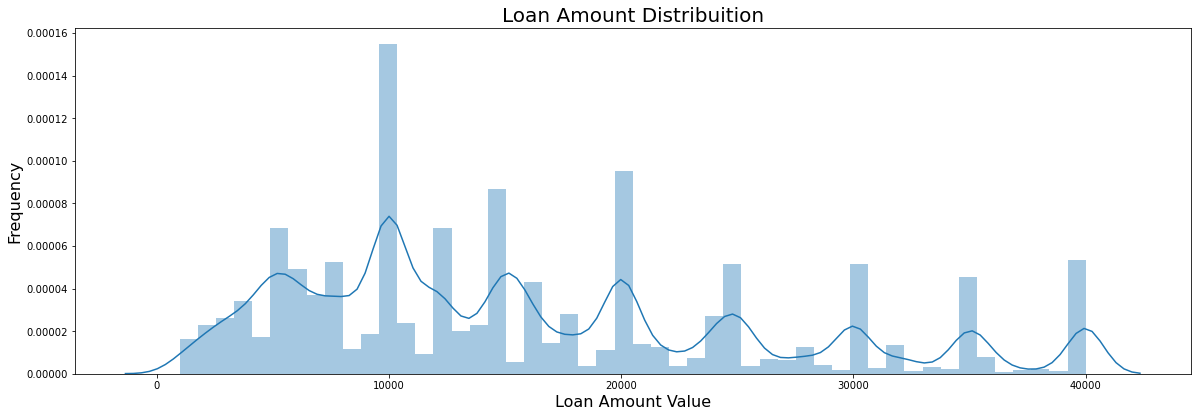

In [32]:
loan_amount = df1["loan_amnt"].values
funded_amount = df1["funded_amnt"].values
investor_funds = df1["funded_amnt_inv"].values

plt.figure(figsize=(20,14))

#plotting distribution of loan amount
plt.subplot(211)
g = sns.distplot(loan_amount)
g.set_xlabel("Loan Amount Value", fontsize=16)
g.set_ylabel("Frequency", fontsize=16)
g.set_title("Loan Amount Distribuition", fontsize=20)

Text(0.5, 1.0, 'Funded Amount Distribution')

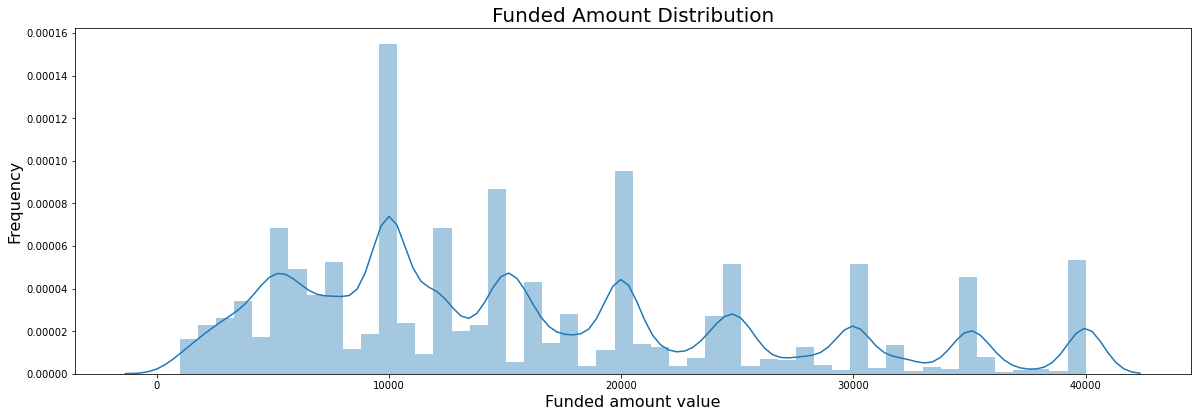

In [38]:
#plotting the overall fulfillment rate by the company of the loans requested
plt.figure(figsize=(20,14))

plt.subplot(212)
f = sns.distplot(funded_amount)
f.set_xlabel("Funded amount value", fontsize=16)
f.set_ylabel("Frequency", fontsize=16)
f.set_title("Funded Amount Distribution", fontsize=20)

Text(0.5, 1.0, 'Investor Funded Amount Distribution')

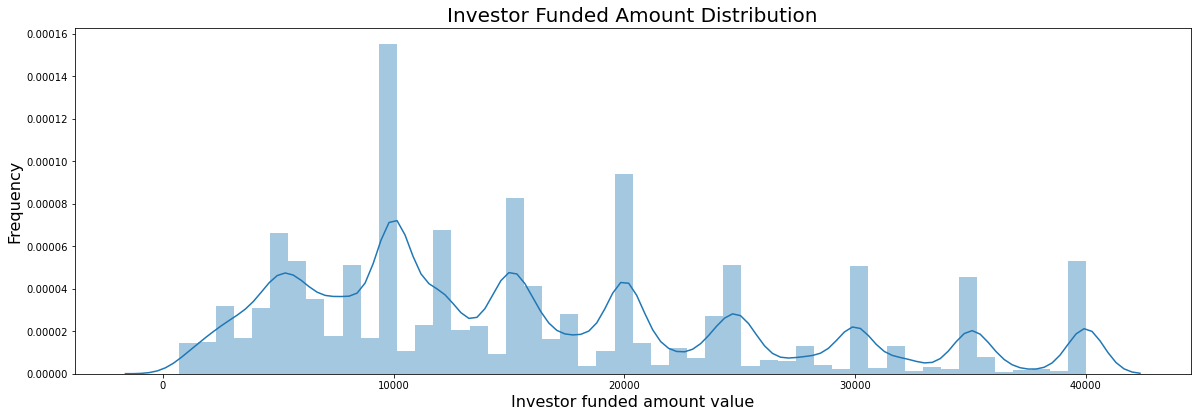

In [36]:
#plotting the distribution of loan amount fulfillment by investors
plt.figure(figsize=(20,14))

plt.subplot(212)
h = sns.distplot(investor_funds)
h.set_xlabel("Investor funded amount value", fontsize=16)
h.set_ylabel("Frequency", fontsize=16)
h.set_title("Investor Funded Amount Distribution", fontsize=20)

In [63]:
df1['int_round'].describe()

count    495242.000000
mean         12.687654
std           5.156466
min           5.000000
25%           8.000000
50%          12.000000
75%          16.000000
max          31.000000
Name: int_round, dtype: float64

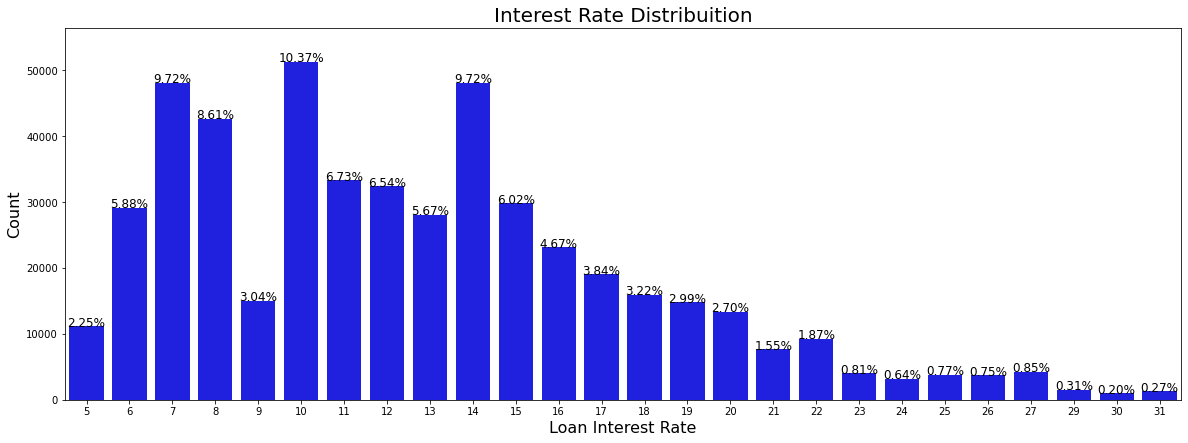

In [59]:
total = len(df1)
plt.figure(figsize=(20,16))
plt.subplot(212)
g1 = sns.countplot(x="int_round", data=df1, 
                  color='blue')
g1.set_xlabel("Loan Interest Rate", fontsize=16)
g1.set_ylabel("Count", fontsize=16)
g1.set_title("Interest Rate Distribuition", fontsize=20)
sizes=[] # Get highest values in y
for p in g1.patches:
    height = p.get_height()
    sizes.append(height)
    g1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12) 
g1.set_ylim(0, max(sizes) * 1.10) # set y limit based on highest heights

plt.subplots_adjust(hspace = 0.4,top = 0.9)

plt.show()

## Checking for missing values

Once we are done with a basic analysis of the numerical variables like loan,interest etc we are going to check if there are any missing values in the data.

In [143]:
nan_mean = df2.isna().mean()
nan_mean = nan_mean[nan_mean != 0].sort_values()
nan_mean

emp_length                  0.084781
sec_app_earliest_cr_line    0.860704
dtype: float64

In [ ]:
df2 = df2.drop(['desc', 'member_id'], axis=1, errors='ignore')

Removing these two columns as they are completely empty so let's remove them as there are only missing values in them

## Handling Missing values
Taking care of missing values in the above columns by filling them appropriately.
There are some categorical variables which can be filled with empty strings.To check which ones are categorical variables we can check in the cleaned dataset and take a difference of sets twice.

In [128]:
m=pd.DataFrame(nan_mean)
m.index
f=list(m.index)
f
cat_cols=df2.select_dtypes('object').columns.values

In [135]:
#finding out which are categorical variables from f
set1=np.setdiff1d(f,cat_cols)
set2=np.setdiff1d(f,set1)
set2

array(['emp_title', 'verification_status_joint'], dtype='<U35')

We find that there are two categorical variables,so their missing values can be filled by an empty string

In [142]:
fill_empty = ['emp_title', 'verification_status_joint']
fill_max = ['bc_open_to_buy', 'mo_sin_old_il_acct', 'mths_since_last_delinq',
            'mths_since_last_major_derog', 'mths_since_last_record',
            'mths_since_rcnt_il', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
            'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
            'pct_tl_nvr_dlq','sec_app_mths_since_last_major_derog']
fill_min = np.setdiff1d(df2.columns.values, np.append(fill_empty, fill_max))


df2[fill_empty] = df2[fill_empty].fillna('')
df2[fill_max] = df2[fill_max].fillna(X[fill_max].max())
df2[fill_min] = df2[fill_min].fillna(X[fill_min].min()) 


There are some numerical variables which have to be filled with maximum of their respective columns and there are some which have to be filled with min of their column.

For example the 'feature mths_since_last_record' indicates the number of months since the last record (like bankruptcy, foreclosure, tax liens, etc.) so if missing, one should assume that no records were made and the number of months since the "last" record should be a maximum.

 the feature emp_length indicates the number of working years so if missing, one should assume that the borrower never worked and the number of working years should be a minimum.


## Checking for multicollinearity

In [140]:
#getting numerical values for multicollinearity
numerical = df2.select_dtypes('number').columns.values
df2[numerical].nunique().sort_values()

acc_now_delinq                     2
num_tl_30dpd                       2
inq_last_6mths                     6
sec_app_inq_last_6mths             7
open_il_12m                        8
                               ...  
total_bal_il                  115553
total_il_high_credit_limit    128691
total_bal_ex_mort             139900
tot_cur_bal                   254794
tot_hi_cred_lim               266282
Length: 88, dtype: int64

 We can see that number id has 0 values and id has amount of values equivalent to number of rows so we have to remove these two as they are redundant

In [136]:
df2 = df2.drop(['num_tl_120dpd_2m', 'id'], axis=1, errors='ignore')

In [146]:
fill_max

['bc_open_to_buy',
 'mo_sin_old_il_acct',
 'mths_since_last_delinq',
 'mths_since_last_major_derog',
 'mths_since_last_record',
 'mths_since_rcnt_il',
 'mths_since_recent_bc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq',
 'pct_tl_nvr_dlq',
 'sec_app_mths_since_last_major_derog']

In [138]:
#calculating collinearity of all the remaining pairs 
#num_feat = df2.select_dtypes('number').columns.values
#comb_num_feat = np.array(list(combinations(num_feat, 2)))
#corr_num_feat = np.array([])
#for comb in comb_num_feat:
#   corr = pearsonr(df2[comb[0]], df2[comb[1]])[0]
#    corr_num_feat = np.append(corr_num_feat, corr)

ValueError: array must not contain infs or NaNs

In [216]:
#checking again for missing values
nan_mean = df2.isna().mean()
nan_mean = nan_mean[nan_mean != 0].sort_values()
nan_mean

Series([], dtype: float64)

Removing missing values again

In [151]:

df2['emp_length'] = df2['emp_length'].fillna(0)
df2['sec_app_earliest_cr_line'] = df2['sec_app_earliest_cr_line'].fillna('')


In [191]:
#checking again for missing values
nan_mean = df2.isna().mean()
nan_mean = nan_mean[nan_mean != 0].sort_values()
nan_mean

Series([], dtype: float64)

In [178]:
#calculating collinearity of all the remaining pairs 
corr_matrix=df2.corr()
corr_matrix

,acc_now_delinq,acc_open_past_24mths,all_util,annual_inc,annual_inc_joint,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,collections_12_mths_ex_med,...,tot_coll_amt,tot_cur_bal,tot_hi_cred_lim,total_acc,total_bal_ex_mort,total_bal_il,total_bc_limit,total_cu_tl,total_il_high_credit_limit,total_rev_hi_lim
acc_now_delinq,1.000000,0.000595,0.001577,0.002223,-0.002342,0.002735,-0.001785,0.004233,-0.000531,0.006732,...,-0.000122,0.003186,0.003238,0.001606,0.003323,0.003257,0.000154,-0.002363,0.003766,0.002094
acc_open_past_24mths,0.000595,1.000000,-0.048572,0.067133,-0.021163,-0.038493,-0.002213,-0.190753,0.007842,0.010586,...,0.005910,0.148607,0.161565,0.451676,0.167964,0.198260,0.118501,0.166048,0.187366,0.166119
all_util,0.001577,-0.048572,1.000000,0.027808,0.017138,0.113275,-0.106666,0.591508,-0.004294,-0.018101,...,-0.002550,0.118365,0.036605,0.003324,0.293198,0.276746,-0.265226,0.062649,0.226714,-0.226508
annual_inc,0.002223,0.067133,0.027808,1.000000,0.055874,0.237363,0.019549,0.036268,0.004877,-0.005136,...,-0.000972,0.332118,0.351816,0.165724,0.277255,0.184499,0.239032,0.050461,0.240206,0.260952
annual_inc_joint,-0.002342,-0.021163,0.017138,0.055874,1.000000,0.163066,0.024490,0.016666,-0.008340,-0.017162,...,-0.002396,0.172602,0.175506,0.037858,0.106639,0.083083,0.043821,0.057242,0.110927,0.068366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
total_bal_il,0.003257,0.198260,0.276746,0.184499,0.083083,0.223751,0.008451,0.026284,0.000793,-0.004340,...,-0.000745,0.421209,0.393826,0.433172,0.903837,1.000000,0.112213,0.143048,0.950167,0.126052
total_bc_limit,0.000154,0.118501,-0.265226,0.239032,0.043821,0.092530,0.121157,-0.188945,-0.020673,-0.029523,...,-0.006122,0.298542,0.406877,0.356529,0.300508,0.112213,1.000000,0.000692,0.170787,0.819125
total_cu_tl,-0.002363,0.166048,0.062649,0.050461,0.057242,0.085895,0.072405,-0.019260,0.004366,-0.006074,...,-0.001974,0.151993,0.157469,0.312378,0.153063,0.143048,0.000692,1.000000,0.173405,0.083176
total_il_high_credit_limit,0.003766,0.187366,0.226714,0.240206,0.110927,0.242572,0.014526,0.047126,0.002215,-0.005493,...,-0.001484,0.461592,0.463492,0.460200,0.888667,0.950167,0.170787,0.173405,1.000000,0.185426


In [192]:
num_feat = df2.select_dtypes('number').columns.values
comb_num_feat = np.array(list(combinations(num_feat, 2)))
corr_num_feat = np.array([])
for comb in comb_num_feat:
    corr = pearsonr(df2[comb[0]], df2[comb[1]])[0]
    corr_num_feat = np.append(corr_num_feat, corr)

In [193]:
high_corr_num = comb_num_feat[np.abs(corr_num_feat) >= 0.9]
high_corr_num


array([['acc_now_delinq', 'num_tl_30dpd'],
       ['fico_range_high', 'fico_range_low'],
       ['funded_amnt', 'installment'],
       ['funded_amnt', 'loan_amnt'],
       ['installment', 'loan_amnt'],
       ['mo_sin_old_il_acct', 'mths_since_rcnt_il'],
       ['num_actv_rev_tl', 'num_rev_tl_bal_gt_0'],
       ['num_sats', 'open_acc'],
       ['sec_app_fico_range_high', 'sec_app_fico_range_low'],
       ['sec_app_num_rev_accts', 'sec_app_open_acc'],
       ['tot_cur_bal', 'tot_hi_cred_lim'],
       ['total_bal_ex_mort', 'total_bal_il'],
       ['total_bal_il', 'total_il_high_credit_limit']], dtype='<U35')

We will check for values with collinearity above 0.9

In [194]:
df2= df2.drop(np.unique(high_corr_num[:, 0]), axis=1, errors='ignore')

In [217]:
cat_feat = df2.select_dtypes('object').columns.values
df2[cat_feat].nunique().sort_values()

application_type               2
disbursement_method            2
initial_list_status            2
term                           2
verification_status            3
home_ownership                 4
verification_status_joint      4
grade                          7
purpose                       13
addr_state                    50
sec_app_earliest_cr_line     646
dtype: int64

In [225]:
df2['verification_status_joint'].unique()

array(['', 'Not Verified', 'Verified', 'Source Verified'], dtype=object)

Url has as many unique values as the number of rows and emp_title also has a lot of unique values to calculate correlation so removing both of them

In [197]:
df2 = df2.drop(['url', 'emp_title'], axis=1, errors='ignore')


Calculating Cramer's V correlation for categorical variables 

In [199]:
np.seterr(divide='ignore', invalid='ignore')
cat_feat = df2.select_dtypes('object').columns.values
comb_cat_feat = np.array(list(combinations(cat_feat, 2)))
corr_cat_feat = np.array([])
for comb in comb_cat_feat:
    table = pd.pivot_table(X, values='loan_amnt', index=comb[0], columns=comb[1], aggfunc='count').fillna(0)
    corr = np.sqrt(chi2_contingency(table)[0] / (table.values.sum() * (np.min(table.shape) - 1) ) )
    corr_cat_feat = np.append(corr_cat_feat, corr)

In [200]:
high_corr_cat = comb_cat_feat[corr_cat_feat >= 0.9]
high_corr_cat

array([['addr_state', 'zip_code'],
       ['grade', 'sub_grade'],
       ['purpose', 'title']], dtype='<U25')

In [201]:
df2 = df2.drop(np.unique(high_corr_cat[:, 1]), axis=1, errors='ignore')


Removing one of the two variables from each list object

In [215]:
corr_cat_feat

array([0.06777557, 0.01967258, 0.01740946, 0.14608464, 0.01563901,
       0.02263938, 0.0967608 , 0.01209159, 0.04116498, 0.02347855,
       0.03801804, 0.04576782, 0.99776351, 0.08245357, 0.06953955,
       0.14354545, 0.01300502, 0.07686784,        nan, 0.0784318 ,
       0.0967495 , 0.07685791, 0.12839071,        nan, 0.1162327 ,
       0.27199944, 0.02358611, 0.05906754, 0.2740072 , 0.10759567,
       0.34741179, 0.01951398, 0.2740072 , 0.0506869 ,        nan,
       0.05522378, 0.04395608, 0.15540598, 0.0680148 , 0.10702581,
       1.        , 0.33047124, 0.067998  , 0.15308506, 0.08987679,
       0.04859759, 0.04272198, 0.11183463, 0.2051105 , 0.05346076,
       0.10876103, 0.11183166, 0.05720043, 0.04173194, 0.20899105,
       0.05013569, 0.10703191, 0.16947644, 0.17437337, 0.05010761,
       0.00963794, 0.00433748, 0.04578807, 0.10324299, 0.05424702,
       0.10890095, 1.        , 0.06818489, 0.04968397, 0.0523617 ,
       0.09484391, 0.1277503 , 0.10324299, 0.10598474, 0.11030